In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [2]:
pd.options.display.float_format = '{:.1f}%'.format

# Leggi i dati dal file CSV
data = pd.read_csv('sp500_data.csv')

# Calcola la variazione percentuale tra la chiusura di un giorno e la chiusura del giorno successivo
data['Percent Change'] = data['close'].pct_change() * 100

# Rimuovi i valori NaN
data = data.dropna()

# memorizzo la data più vecchia del dataset senza orario
start_date = pd.to_datetime(data['date']).dt.date.min()

In [3]:
# Creazione della figura e dell'asse
fig, ax = plt.subplots()
plt.close(fig)  # Evita la duplicazione del grafico
fig.set_size_inches(1000 / fig.dpi, 600 / fig.dpi)  # Imposta la dimensione della figura in pixel (1920x1080)

# Funzione per aggiornare il grafico
def update_graph(percentile):
    ax.clear()  # Pulisce il grafico precedente
    left_bound = data['Percent Change'].quantile(1 - percentile)

    ax.hist(data['Percent Change'], bins=500, edgecolor='blue')
    ax.set_title(f'Distribuzione delle variazioni percentuali con limite al {percentile * 100:.0f}%')
    ax.set_xlabel(f'Variazione percentuale SP500 dal {start_date}')
    ax.set_ylabel('Frequenza')

    # Linea verticale del limite percentile
    ax.axvline(left_bound, color='red', linestyle='dashed', linewidth=1)
    ax.text(left_bound, ax.get_ylim()[1] * 0.9, f'{left_bound:.2f}%', color='red', ha='right')

    display(fig)  # Mostra il grafico aggiornato
   
# Crea uno slider per modificare il valore di percentile
slider = widgets.FloatSlider(value=0.75, min=0.01, max=1.0, step=0.01, description='Percentile:')
slider.layout.width = '800px'  # Imposta la larghezza dello slider
# Collegamento della funzione allo slider
output = widgets.interactive_output(update_graph, {'percentile': slider})

# Visualizzazione
display(slider, output)

FloatSlider(value=0.75, description='Percentile:', layout=Layout(width='800px'), max=1.0, min=0.01, step=0.01)

Output()

In [5]:
# Creazione della figura e dell'asse
fig2, ax2 = plt.subplots()
plt.close(fig2)  # Evita la duplicazione del grafico
fig2.set_size_inches(1000 / fig2.dpi, 600 / fig2.dpi)  # Imposta la dimensione della figura in pixel (1920x1080)

# Funzione per aggiornare il grafico con limiti superiore e inferiore
def update_graph_with_bounds(percentile):
    ax2.clear()  # Pulisce il grafico precedente
    lower_bound = data['Percent Change'].quantile((1 - percentile) / 2)
    upper_bound = data['Percent Change'].quantile(1 - (1 - percentile) / 2)

    ax2.hist(data['Percent Change'], bins=500, edgecolor='blue')
    ax2.set_title(f'Distribuzione delle variazioni percentuali con limiti centrati al {percentile * 100:.0f}%')
    ax2.set_xlabel(f'Variazione percentuale SP500 dal {start_date}')
    ax2.set_ylabel('Frequenza')

    # Linee verticali dei limiti percentili
    ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1)
    ax2.axvline(upper_bound, color='green', linestyle='dashed', linewidth=1)
    ax2.text(lower_bound, ax2.get_ylim()[1] * 0.9, f'{lower_bound:.2f}%', color='red', ha='right')
    ax2.text(upper_bound, ax2.get_ylim()[1] * 0.9, f'{upper_bound:.2f}%', color='green', ha='left')

    display(fig2)  # Mostra il grafico aggiornato
   
# Crea uno slider per modificare il valore di percentile
slider2 = widgets.FloatSlider(value=0.75, min=0.01, max=1.0, step=0.01, description='Percentile:')
slider2.layout.width = '800px'  # Imposta la larghezza dello slider
# Collegamento della funzione allo slider
output2 = widgets.interactive_output(update_graph_with_bounds, {'percentile': slider2})

# Visualizzazione
display(slider2, output2)

FloatSlider(value=0.75, description='Percentile:', layout=Layout(width='800px'), max=1.0, min=0.01, step=0.01)

Output()

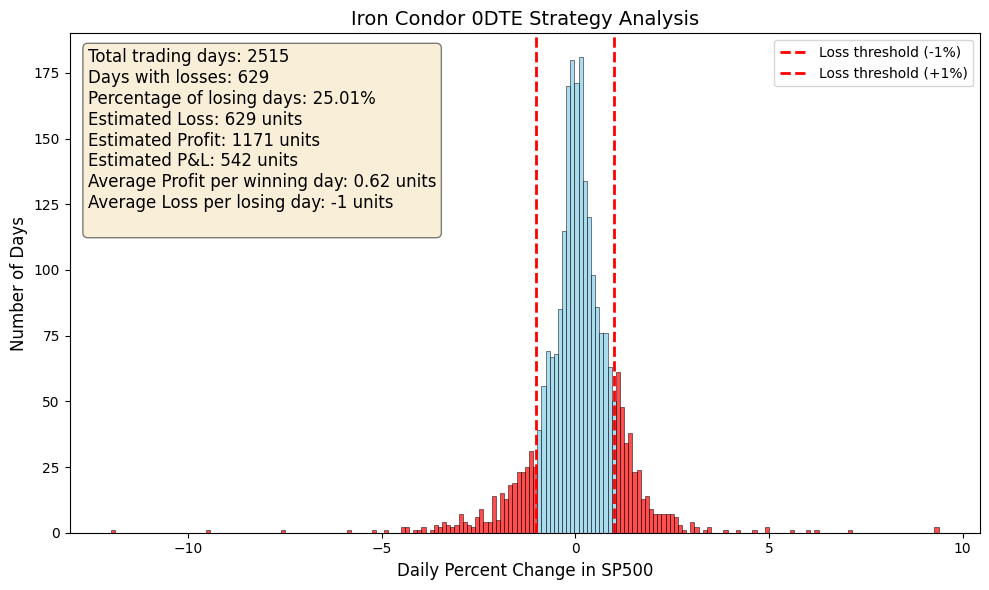

In [6]:
# Calculate the number of days with losses for an iron condor strategy
# Loss occurs when daily percentage change is greater than +1% or less than -1%
# Define thresholds for iron condor strategy
lower_threshold = -1.0
upper_threshold = 1.0

# Calculate profit for days without losses (when price movement is between thresholds)
# Count the number of days where price movement stays between thresholds
profit_days = data[(data['Percent Change'] >= lower_threshold) & (data['Percent Change'] <= upper_threshold)]
profit_days = profit_days.copy()  # Ensure it's a separate DataFrame
profit_days.loc[:, 'Profit'] = (100 - abs(profit_days['Percent Change'] * 100)) / 100
total_profit = profit_days['Profit'].sum()

# For loss days, we assume a fixed loss of -1 per trade
total_loss = -1 * (data[(data['Percent Change'] < lower_threshold) | 
                                           (data['Percent Change'] > upper_threshold)]).shape[0]

# Calculate net P&L
net_pl = total_profit + total_loss

# Count days with losses
loss_days = data[(data['Percent Change'] > 1.0) | (data['Percent Change'] < -1.0)]
total_days = len(data)
loss_count = len(loss_days)
loss_percentage = (loss_count / total_days) * 100

# Calculate win/loss summary statistics
win_days = len(profit_days)
win_avg = total_profit / win_days if win_days > 0 else 0
loss_avg = total_loss / loss_count if loss_count > 0 else 0

# Create a figure to visualize the results
fig3, ax3 = plt.subplots(figsize=(10, 6))

# Plot the histogram with colored regions
bins = 200
n, bins, patches = ax3.hist(data['Percent Change'], bins=bins, alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5)

# Color the loss regions
for i in range(len(patches)):
    if bins[i] < -1.0 or bins[i] > 1.0:
        patches[i].set_facecolor('red')
        patches[i].set_alpha(0.7)

# Add vertical lines at the boundaries
ax3.axvline(-1.0, color='red', linestyle='--', linewidth=2, label='Loss threshold (-1%)')
ax3.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Loss threshold (+1%)')

# Add annotations
ax3.set_title('Iron Condor 0DTE Strategy Analysis', fontsize=14)
ax3.set_xlabel('Daily Percent Change in SP500', fontsize=12)
ax3.set_ylabel('Number of Days', fontsize=12)
ax3.legend()

# Add text box with statistics
stats_text = (f'Total trading days: {total_days}\n'
                          f'Days with losses: {loss_count}\n'
                          f'Percentage of losing days: {loss_percentage:.2f}%\n'
                          f'Estimated Loss: {loss_count:.0f} units\n'
                          f'Estimated Profit: {total_profit:.0f} units\n'
                          f'Estimated P&L: {net_pl:.0f} units\n'
                          f'Average Profit per winning day: {win_avg:.2f} units\n'
                          f'Average Loss per losing day: {loss_avg:.0f} units\n')

ax3.text(0.02, 0.97, stats_text, transform=ax3.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [13]:
# Create a function to calculate and return stats_text dynamically
def calculate_stats(lower_threshold, upper_threshold):
    profit_days = data[(data['Percent Change'] >= lower_threshold) & (data['Percent Change'] <= upper_threshold)]
    profit_days = profit_days.copy()
    profit_days.loc[:, 'Profit'] = (100 - abs(profit_days['Percent Change'] * 100)) / 100
    total_profit = profit_days['Profit'].sum()

    total_loss = -1 * (data[(data['Percent Change'] < lower_threshold) | 
                            (data['Percent Change'] > upper_threshold)]).shape[0]

    net_pl = total_profit + total_loss
    loss_days = data[(data['Percent Change'] > upper_threshold) | (data['Percent Change'] < lower_threshold)]
    total_days = len(data)
    loss_count = len(loss_days)
    loss_percentage = (loss_count / total_days) * 100

    win_days = len(profit_days)
    win_avg = total_profit / win_days if win_days > 0 else 0
    loss_avg = total_loss / loss_count if loss_count > 0 else 0

    return (f'Total trading days: {total_days}\n'
            f'Days with losses: {loss_count}\n'
            f'Percentage of losing days: {loss_percentage:.2f}%\n'
            f'Estimated Loss: {loss_count:.0f} units\n'
            f'Estimated Profit: {total_profit:.0f} units\n'
            f'Estimated P&L: {net_pl:.0f} units\n'
            f'Average Profit per winning day: {win_avg:.2f} units\n'
            f'Average Loss per losing day: {loss_avg:.0f} units\n')

# Create widgets for dynamic thresholds
lower_slider = widgets.FloatSlider(value=-1.0, min=-5.0, max=0.0, step=0.1, description='Lower Threshold:')
upper_slider = widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='Upper Threshold:')
stats_output = widgets.Output()

# Function to update the stats dynamically
def update_stats(lower_threshold, upper_threshold):
    with stats_output:
        stats_output.clear_output()
        stats_text = calculate_stats(lower_threshold, upper_threshold)
        print(stats_text)

# Link sliders to the update function
widgets.interactive(update_stats, lower_threshold=lower_slider, upper_threshold=upper_slider)

# Display sliders and stats output
display(lower_slider, upper_slider, stats_output)

# Creazione della figura e dell'asse per il grafico dinamico
fig4, ax4 = plt.subplots()
plt.close(fig4)  # Evita la duplicazione del grafico
fig4.set_size_inches(10, 6)  # Imposta la dimensione della figura

# Funzione per aggiornare il grafico dinamicamente
def update_dynamic_graph(lower_threshold, upper_threshold):
    ax4.clear()  # Pulisce il grafico precedente
    
    # Filtra i dati in base ai limiti selezionati
    filtered_data = data[(data['Percent Change'] >= lower_threshold) & (data['Percent Change'] <= upper_threshold)]
    
    # Istogramma dei dati filtrati
    ax4.hist(filtered_data['Percent Change'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    
    # Aggiungi titolo e etichette
    ax4.set_title('Distribuzione delle variazioni percentuali filtrate', fontsize=14)
    ax4.set_xlabel('Variazione percentuale SP500', fontsize=12)
    ax4.set_ylabel('Frequenza', fontsize=12)
    
    # Mostra i limiti selezionati
    ax4.axvline(lower_threshold, color='red', linestyle='--', linewidth=2, label=f'Limite inferiore ({lower_threshold:.2f}%)')
    ax4.axvline(upper_threshold, color='green', linestyle='--', linewidth=2, label=f'Limite superiore ({upper_threshold:.2f}%)')
    ax4.legend()
    
    # Mostra il grafico aggiornato
    display(fig4)

# Collegamento della funzione agli slider
output_dynamic_graph = widgets.interactive_output(update_dynamic_graph, {'lower_threshold': lower_slider, 'upper_threshold': upper_slider})

# Visualizzazione del grafico dinamico
display(output_dynamic_graph)

FloatSlider(value=-1.0, description='Lower Threshold:', max=0.0, min=-5.0)

FloatSlider(value=1.0, description='Upper Threshold:', max=5.0)

Output()

Output()